# Mean Images

Question: Is there a difference in the IR image between a host galaxy and a non-host galaxy? What about in the radio image?

To investigate this question, I will make a set of host galaxies and non-host galaxies. Then I will average each set in both a feature space and the image space and visualise the results.

In [1]:
import collections
import pprint
import sys
import timeit
import warnings

import matplotlib.pyplot
import numpy
import scipy.stats
import sklearn.cluster
import sklearn.mixture


sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.show
import crowdastro.rgz_analysis.consensus

%matplotlib inline
warnings.simplefilter('ignore', UserWarning)  # astropy always raises warnings on Windows.

In [100]:
# PG-means method for finding peaks (from click_consensus).
def make_annotation_signature(annotation):
    """Generates the signature associated with an annotation."""
    if 'radio' not in annotation:
        # Metadata (ignore this).
        return None

    # We want to turn the radio classifications into a unique signature. I can just take all the xmax's and ymax's
    # and put them into some tuples (xmaxs, ymaxs).
    
    # Having no contours is a special case; () to avoid type errors (it's special but it's still valid!)
    if annotation['radio'] == 'No Contours':
        return ()

    xmaxs = tuple(sorted([round(float(r['xmax']), 14) for r in annotation['radio'].values()]))
    ymaxs = tuple(sorted([round(float(r['ymax']), 14) for r in annotation['radio'].values()]))
    signature = (xmaxs, ymaxs)
    return signature

def make_classification_signature(classification):
    """Generates the signature associated with a radio classification."""
    classification_signature = []
    for annotation in classification['annotations']:
        annotation_signature = make_annotation_signature(annotation)
        if annotation_signature is not None:
            classification_signature.append(annotation_signature)

    classification_signature = tuple(sorted(classification_signature))
    return classification_signature

def pg_means(points, significance=0.01, projections=12):
    """Cluster points with the PG-means algorithm."""
    k = 1
    
    while True:
        # Fit a Gaussian mixture model with k components.
        gmm = sklearn.mixture.GMM(n_components=k)
        try:
            gmm.fit(points)
        except ValueError:
            return None

        
        for _ in range(projections):
            # Project the data to one dimension.
            projection_vector = numpy.random.random(size=(2,))
            projected_points = points @ projection_vector
            # Project the model to one dimension.
            # We need the CDF in one dimension, so we'll sample some data points and project them.
            n_samples = 1000
            samples = gmm.sample(n_samples) @ projection_vector
            samples.sort()
            
            def cdf(x):
                for sample, y in zip(samples, numpy.arange(n_samples) / n_samples):
                    if sample >= x:
                        break
                return y
            
            _, p_value = scipy.stats.kstest(projected_points, numpy.vectorize(cdf))
            if p_value < significance:
                # Reject the null hypothesis.
                break
        else:
            # Null hypothesis was not broken.
            return gmm
        
        k += 1

def find_plurality_radio_signature(subject):
    n_signatures = collections.Counter()
    
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        classification_signature = make_classification_signature(classification)
        n_signatures[classification_signature] += 1

    plurality_radio_signature = max(n_signatures, key=n_signatures.get)
    return plurality_radio_signature

def subject_consensus(subject):
    """
    Returns dict:
        plurality_radio_signature: Unique signature of the plurality radio combination.
        plurality_clicks: Map from radio signature to IR source identified by volunteers' clicks.
        n_total: Total number of volunteers that classified this subject.
        n_agree: Total number of volunteers that agree on both the radio combination and IR sources.
        n_agree_radio: Total number of volunteers that agree on the radio combination, ignoring IR.
    """
    n_total = 0
    n_agree = 0
    n_agree_radio = 0

    plurality_radio_signature = find_plurality_radio_signature(subject)
    
    # Find how many volunteers agree on the radio combination.
    # Separate clicks into which radio signature they are associated with.
    # Only do this if the volunteer agrees on the radio classification.
    signature_to_clicks = collections.defaultdict(list)
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        n_total += 1

        classification_signature = make_classification_signature(classification)
        if classification_signature != plurality_radio_signature:
            continue
        
        n_agree_radio += 1
        
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue  # Skip metadata.
            
            # We ignore multiple clicks and instead just use the first click.
            if annotation['ir'] == 'No Sources':
                first_click = None
            else:
                first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
            signature_to_clicks[annotation_signature].append(first_click)
    
    # For each radio signature, cluster the clicks and find the plurality click.
    plurality_clicks = {}
    signature_to_cluster = {}
    signature_to_gmm = {}
    for radio_signature, clicks in signature_to_clicks.items():
        clicks = [click for click in clicks if click is not None]
        gmm = pg_means(clicks)
        if gmm is None:
            continue

        signature_to_gmm[radio_signature] = gmm
        signature_to_cluster[radio_signature] = gmm.weights_.argmax()
        plurality_clicks[radio_signature] = gmm.means_[gmm.weights_.argmax()]
    
    # Find how many volunteers agree with the plurality clicks *and* the plurality radio signature.
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        classification_signature = make_classification_signature(classification)
        if classification_signature != plurality_radio_signature:
            continue
        
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue  # Skip metadata.
            
            if annotation_signature not in signature_to_gmm:
                continue # Skip overfits.
            
            if annotation['ir'] == 'No Sources':
                first_click = None
            else:
                # TODO(MatthewJA): Don't ignore 'No Sources'!
                first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
                cluster = signature_to_gmm[annotation_signature].predict([first_click])
                if cluster != signature_to_cluster[annotation_signature]:
                    break
        else:
            # All agreed!
            n_agree += 1
    
    return {
        'plurality_radio_signature': plurality_radio_signature,
        'plurality_clicks': plurality_clicks,
        'n_total': n_total,
        'n_agree': n_agree,
        'n_agree_radio': n_agree_radio,
        'signature_to_gmm_': signature_to_gmm,
    }

def get_clicks(subject):
    clicks = []
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue
    
            if annotation['ir'] == 'No Sources':
                clicks.append(None)
            else:
                first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
                clicks.append(first_click)
    return numpy.array(clicks)

# Potential host finding (from potential_host_counting).
def potential_hosts(subject):
    """Finds potential hosts in a subject image.
    
    subject: Zooniverse subject.
    -> (list of brightnesses, list of coordinates)
    """
    neighborhood = numpy.ones((10, 10))
    infrared = crowdastro.data.get_ir(subject)
    blurred_infrared = scipy.ndimage.filters.gaussian_filter(infrared, 1)
    local_max = scipy.ndimage.filters.maximum_filter(blurred_infrared, footprint=neighborhood) == blurred_infrared
    region_labels, n_labels = scipy.ndimage.measurements.label(local_max)
    maxima = numpy.array(
                [numpy.array((region_labels == i + 1).nonzero()).T.mean(axis=0)
                 for i in range(n_labels)]
    )
    maxima = maxima[numpy.logical_and(maxima[:, 1] != 0, maxima[:, 1] != 499)]
    values = [infrared[tuple(m)] for m in maxima]
    return values, maxima

## Creating the sets of galaxies

I want a set of host galaxies and a set of non-host galaxies. To do this, I'll iterate over some large number of subjects, figure out where all the potential hosts are, figure out which points volunteers have selected as host galaxies, then declare the potential hosts closest to these points as "host galaxies". The rest become "non-host galaxies".

In [179]:
host_galaxies = []
non_host_galaxies = []
host_radio = []
non_host_radio = []
real_hosts = []
found_hosts = []
n = 500

for subject in crowdastro.data.db.radio_subjects.find({'metadata.survey': 'atlas', 'state': 'complete'}).limit(n):
    p_hosts = potential_hosts(subject)[1]
    consensus = subject_consensus(subject)
    
    consensus_hosts = list(consensus['plurality_clicks'].values())
#     for answer in consensus['answer'].values():
#         try:
#             consensus_hosts.append(answer['ir_peak'])
#         except KeyError:
#             consensus_hosts.append(answer.get('ir', None))
    
    radius = 24
    ir = numpy.pad(crowdastro.data.get_ir(subject), radius, mode='constant')
    radio = numpy.pad(crowdastro.data.get_radio(subject), radius, mode='constant')
    
    hosts = set()
    for host in consensus_hosts:
        if host is not None:
            host = (host[0] * crowdastro.config.get('click_to_fits_x'), host[1] * crowdastro.config.get('click_to_fits_y'))
            real_hosts.append(host)
            nearest = tuple(min(p_hosts, key=lambda z: numpy.hypot(z[0] - host[0], z[1] - host[1])))
            hosts.add(nearest)
    
    for host in p_hosts:
        host_x, host_y = host
        ir_neighbourhood = ir[int(host_x) : int(host_x) + 2 * radius, int(host_y) : int(host_y) + 2 * radius]
        radio_neighbourhood = radio[int(host_x) : int(host_x) + 2 * radius, int(host_y) : int(host_y) + 2 * radius]
        if tuple(host) in hosts:
            found_hosts.append(host)
            host_galaxies.append(ir_neighbourhood)
            host_radio.append(radio_neighbourhood)
        else:
            non_host_galaxies.append(ir_neighbourhood)
            non_host_radio.append(radio_neighbourhood)

host_galaxies = numpy.array(host_galaxies)
non_host_galaxies = numpy.array(non_host_galaxies)
real_hosts = numpy.array(real_hosts)
found_hosts = numpy.array(found_hosts)

K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:201: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [180]:
host_radio = numpy.array(host_radio)
non_host_radio = numpy.array(non_host_radio)

## Means

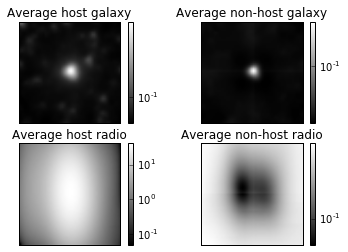

In [191]:
matplotlib.pyplot.subplot(2, 2, 1)
crowdastro.show.image(host_galaxies.mean(axis=0))
matplotlib.pyplot.title('Average host galaxy')
matplotlib.pyplot.gca().axes.get_xaxis().set_visible(False)
matplotlib.pyplot.gca().axes.get_yaxis().set_visible(False)
matplotlib.pyplot.colorbar()

matplotlib.pyplot.subplot(2, 2, 2)
crowdastro.show.image(non_host_galaxies.mean(axis=0))
matplotlib.pyplot.title('Average non-host galaxy')
matplotlib.pyplot.gca().axes.get_xaxis().set_visible(False)
matplotlib.pyplot.gca().axes.get_yaxis().set_visible(False)
matplotlib.pyplot.colorbar()

matplotlib.pyplot.subplot(2, 2, 3)
crowdastro.show.image(host_radio.mean(axis=0))
matplotlib.pyplot.title('Average host radio')
matplotlib.pyplot.gca().axes.get_xaxis().set_visible(False)
matplotlib.pyplot.gca().axes.get_yaxis().set_visible(False)
matplotlib.pyplot.colorbar()

matplotlib.pyplot.subplot(2, 2, 4)
crowdastro.show.image(non_host_radio.mean(axis=0))
matplotlib.pyplot.title('Average non-host radio')
matplotlib.pyplot.gca().axes.get_xaxis().set_visible(False)
matplotlib.pyplot.gca().axes.get_yaxis().set_visible(False)
matplotlib.pyplot.colorbar()

matplotlib.pyplot.show()

So the average host galaxy and the average non-host galaxy are for all intents and purposes identical (the bright spots in the host galaxy average are due to the lower sample size). The average radio images are different; the host radio image is a lot brighter. The dark inside of the non-host radio image could be due to compact sources. There are artefacts in the average non-host means that are due to the 